# 삼성전자 주가 데이터 다운로드
- Yahoo Finance 에서 주가 데이터 다운로드 (https://finance.yahoo.com/)
    - 검색 키워드 '005930.KS' 입력
- 검색 후 Historical Data 선택

![yahoo finance](figures/rnn/21_yahoo_stock1.png)

- `Start Date: 2000년 1월 4일 End Date: 오늘날짜` 선택
- Apply 클릭 후 다운로드
![yahoo finance](figures/rnn/22_yahoo_stock2.png)

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchinfo

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split  

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
# Data loading + EDA
df = pd.read_csv("datasets/005930.KS.csv")
df.shape

(5977, 7)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5977 entries, 0 to 5976
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5977 non-null   object 
 1   Open       5977 non-null   float64
 2   High       5977 non-null   float64
 3   Low        5977 non-null   float64
 4   Close      5977 non-null   float64
 5   Adj Close  5977 non-null   float64
 6   Volume     5977 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 327.0+ KB


In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4514.581055,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4122.971680,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4152.527832,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4093.418213,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4263.359863,46880000


In [6]:
# Date -> datetime 타입으로 변경 -> index 전환.
## 시계열 데이터는 (행) index로 일시를 가지도록 구성.
df['Date'] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5977 entries, 2000-01-04 to 2023-11-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5977 non-null   float64
 1   High       5977 non-null   float64
 2   Low        5977 non-null   float64
 3   Close      5977 non-null   float64
 4   Adj Close  5977 non-null   float64
 5   Volume     5977 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 326.9 KB


In [8]:
# 결측치 확인
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

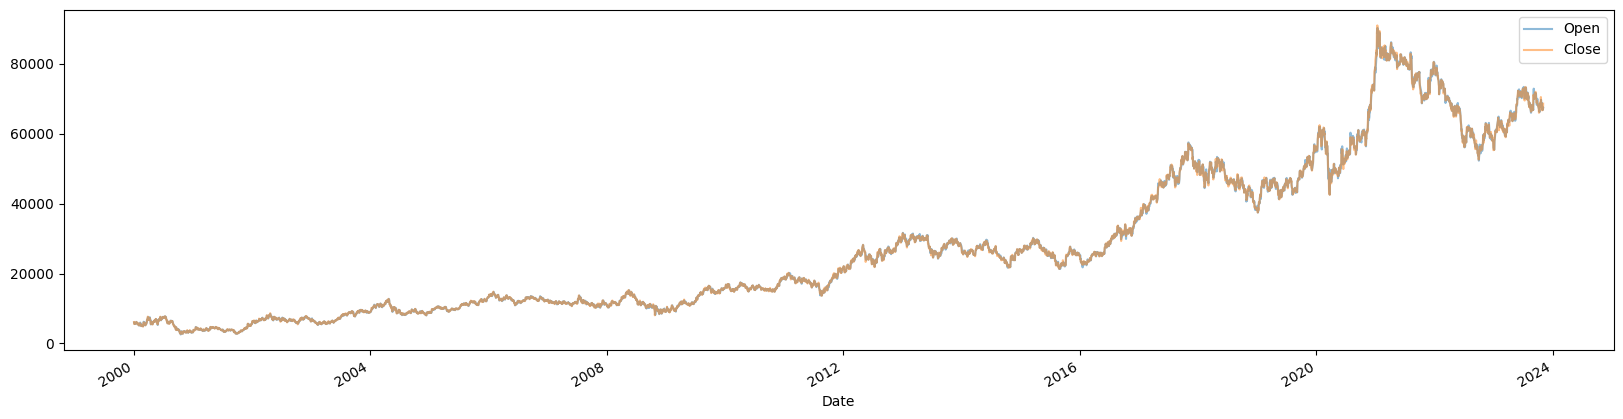

In [11]:
## 시가, 종가의 흐름을 선그래프로 보기
df[['Open', "Close"]].plot(figsize=(20, 5), alpha=0.5);

C:\Users\Playdata\anaconda3\envs\torch\lib\site-packages\matplotlib\axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
C:\Users\Playdata\anaconda3\envs\torch\lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
C:\Users\Playdata\anaconda3\envs\torch\lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
C:\Users\Playdata\anaconda3\envs\torch\lib\site-packages\matplotlib\axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq

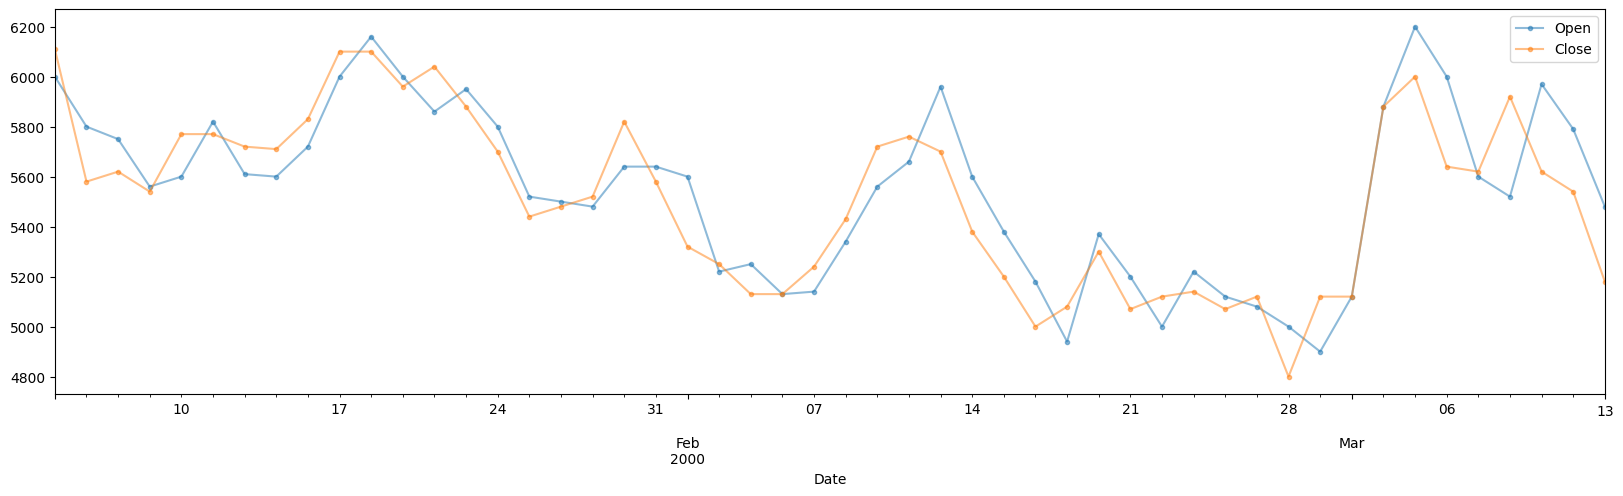

In [15]:
df[['Open', "Close"]][:50].plot(figsize=(20, 5), alpha=0.5, marker='.');

# X와 y를 만들기
- X (input) feature 구성: Open, High, Low, Close, Adj Close, Volumn
- y (output) : Close

In [17]:
y_df = df['Close'].to_frame() # (총데이터수, 1)
X_df = df
X_df.shape, y_df.shape

((5977, 6), (5977, 1))

In [18]:
y_df.head()

,Close
Date,
2000-01-04,6110.0
2000-01-05,5580.0
2000-01-06,5620.0
2000-01-07,5540.0
2000-01-10,5770.0


In [19]:
X_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4514.581055,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4122.971680,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4152.527832,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4093.418213,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4263.359863,46880000


## 전처리
- feature scaling
    - feature 간의 scaling(단위)을 맞추는 작업.
- X: Standard Scaling (평균: 0, 표준편차: 1)
- y: MinMax Scaling (최소: 0, 최대: 1)  => X의 scale과 비슷한 값으로 변환.

In [20]:
#  객체생성 -> fit() -> transform()
X_scaler = StandardScaler()
y_scaler = MinMaxScaler()

X = X_scaler.fit_transform(X_df)
y = y_scaler.fit_transform(y_df)

print(type(X), type(y))
X.shape, y.shape

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


((5977, 6), (5977, 1))

In [21]:
X[:5]

array([[-0.98206102, -0.98155375, -0.99352413, -0.97741812, -0.9041903 ,
         3.48667197],
       [-0.99133206, -0.98385335, -1.00006937, -1.0020065 , -0.92277188,
         3.51861341],
       [-0.99364982, -0.99673113, -0.99726427, -1.00015077, -0.92136946,
         2.18234193],
       [-1.0024573 , -1.00179026, -1.00754964, -1.00386223, -0.92417417,
         1.25472321],
       [-1.0006031 , -0.99719105, -0.99726427, -0.9931918 , -0.91611056,
         1.68774366]])

In [22]:
y[:5]

array([[0.03829161],
       [0.0322873 ],
       [0.03274046],
       [0.03183415],
       [0.03443979]])

###  Sequential Data  구성
- X: 50일치 데이터(ex:1일 ~ 50일), y: 51일째 주가. (ex: 51일)
    - 50일의 연속된 주식데이터를 학습하여 51일째 주가를 예측한다.
    - X의 한개의 데이터가 50일치 주가데이터가 된다.

![img](figures/rnn/20_stock_dataset.png)

[연속된 날짜가 5인 경우]

In [24]:
y.size - 50

5927

In [25]:
timestep = 50  # seq length
data_X = []   # X 데이터를 모을 리스트. X: (50, 6)
data_y = []   # y 값을 모을 리스트

for i in range(0, y.size - timestep): # 총개수-seq_length: 이 이후 반복시에는 남은 데이터가 51개 안되서 데이터 구성이 안됨.
    # X: 0 ~ 50-1, y: 50 ( 1씩 증가)
    _X = X[i:i+timestep]
    _y = y[i+timestep]
    data_X.append(_X)
    data_y.append(_y)

In [29]:
np.shape(data_X), np.shape(data_y)

((5927, 50, 6), (5927, 1))

In [32]:
np.set_printoptions(linewidth=np.inf)  # 한줄에 N개 원소를 출력

In [33]:
data_X[0]

array([[-0.98206102, -0.98155375, -0.99352413, -0.97741812, -0.9041903 ,  3.48667197],
       [-0.99133206, -0.98385335, -1.00006937, -1.0020065 , -0.92277188,  3.51861341],
       [-0.99364982, -0.99673113, -0.99726427, -1.00015077, -0.92136946,  2.18234193],
       [-1.0024573 , -1.00179026, -1.00754964, -1.00386223, -0.92417417,  1.25472321],
       [-1.0006031 , -0.99719105, -0.99726427, -0.9931918 , -0.91611056,  1.68774366],
       [-0.99040495, -0.98201367, -0.98838145, -0.9931918 , -0.91611056,  2.53501486],
       [-1.00013954, -0.99857081, -0.99632923, -0.99551145, -0.91786352,  0.52468036],
       [-1.0006031 , -0.99857081, -0.9981993 , -0.99597539, -0.91821409,  1.31300809],
       [-0.99504047, -0.99213192, -0.9925891 , -0.99040821, -0.91400697,  1.85206093],
       [-0.98206102, -0.97833431, -0.9813687 , -0.97788205, -0.90454095,  2.78264328],
       [-0.97464419, -0.97925415, -0.9785636 , -0.97788205, -0.90454095,  1.58105269],
       [-0.98206102, -0.98477319, -0.979498

In [34]:
y[0]

array([0.03829161])

### Train / test set 분리

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, 
                                                    test_size=0.2)
np.shape(X_train), np.shape(X_test)

((4741, 50, 6), (1186, 50, 6))

### Dataset, DataLoader 구성

In [49]:
# Tensor 변환: 
## X_train: List -> ndarray -> torch.Tensor
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.float32)

In [50]:
# Dataset 생성 -> raw 데이터: 메모리상의 Tensor ===> TensorDataset
trainset = TensorDataset(X_train_tensor, y_train_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)

print('데이터개수:', len(trainset), len(testset))

데이터개수: 4741 1186


In [51]:
# DataLoader 생성
trainloader = DataLoader(trainset, batch_size=200, shuffle=True, 
                         drop_last=True)
testloader = DataLoader(testset, batch_size=200)

print("에폭당 step수:", len(trainloader), len(testloader))

에폭당 step수: 23 6


In [52]:
## 1 step input: (seq, batch, feature) -> (50, 200, 6)

In [54]:
# LSTM layer생성후 추론
a, b = next(iter(trainloader))  # 배치  (X, y)
a.shape, b.shape, a.dtype

(torch.Size([200, 50, 6]), torch.Size([200, 1]), torch.float32)

In [55]:
lstm = nn.LSTM(input_size=6, 
               hidden_size=10, 
#                batch_first=True  #(batch, seq, feature)
              ) 
a = a.permute(1, 0, 2)
o, (h, c) = lstm(a)
o.shape, h.shape, c.shape

(torch.Size([50, 200, 10]), torch.Size([1, 200, 10]), torch.Size([1, 200, 10]))

### 모델 정의

In [56]:
class StockLSTM(nn.Module):
    
    def __init__(self, 
                 input_size:"feature수",
                 hidden_size:"hidden(유닛)수",
                 num_layers:"레이어개수"=1,
                 bidirectional:"양방향여부"=False):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            bidirectional=bidirectional)
        D = 2 if bidirectional else 1
        self.output = nn.Linear(in_features= D*num_layers*hidden_size
                                , out_features=1) # 출력
    def forward(self, X):
        # LSTM(특성을 추출) --hidden state--> Linear -> 예측결과.
        # X: (batch, seq, feature) -> (seq, batch, feature)
        X = X.permute(1, 0, 2)
        out, (hidden_state, cell_state) = self.lstm(X) 
        # hidden state (seq, batch, hidden)
        hidden_state = hidden_state.permute(1, 0, 2)
        hidden_state = nn.Flatten()(hidden_state)
        pred = self.output(hidden_state) # W@X + b 
#         nn.Sigmoid()(pred)  # 0 ~ 1 맞춰줌
        return pred
        

In [57]:
model = StockLSTM(input_size=6, hidden_size=50)

In [59]:
torchinfo.summary(model, (200, 50, 6))

Layer (type:depth-idx)                   Output Shape              Param #
StockLSTM                                [200, 1]                  --
├─LSTM: 1-1                              [50, 200, 50]             11,600
├─Linear: 1-2                            [200, 1]                  51
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
Total mult-adds (M): 116.01
Input size (MB): 0.24
Forward/backward pass size (MB): 4.00
Params size (MB): 0.05
Estimated Total Size (MB): 4.29

### train

In [60]:
# 하이퍼파라미터
N_EPOCH = 1000
LR = 0.0001

INPUT_SIZE = 6
HIDDEN_SIZE = 30
NUM_LAYERS = 1
BIDIRECTIONAL = False

In [62]:
model = StockLSTM(INPUT_SIZE, HIDDEN_SIZE,
                  NUM_LAYERS, BIDIRECTIONAL)
model = model.to(device)

# loss fn = 회귀: MSE
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [65]:
train_loss_list = []
valid_loss_list = []
for epoch in range(N_EPOCH):
    
    model.train()
    train_loss = 0.0
    for X, y in trainloader:
        # 1. device로 이동
        X, y = X.to(device), y.to(device)
        # 2. 추정
        pred = model(X)
        # 3. Loss 계산
        loss = loss_fn(pred, y)
        # 4. grad 계산
        loss.backward()
        # 5. layer의 파라미터들 update
        optimizer.step()
        # 6. gradient 초기화
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(trainloader) # train_loss 평균 계산 
    train_loss_list.append(train_loss)
    
    ## 검증
    model.eval()
    valid_loss = 0.0
    for X_valid, y_valid in testloader:
        # 1. device 이동
        X_valid, y_valid = X_valid.to(device), y_valid.to(device)
        with torch.no_grad():
            # 2. 추정
            pred_valid = model(X_valid)
            # 3. loss 계산
            valid_loss += loss_fn(pred_valid, y_valid).item()
    valid_loss /= len(testloader) # valid_loss의 평균
    valid_loss_list.append(valid_loss)
    if epoch % 100 == 0 or epoch == (N_EPOCH-1):
        print(f"[{epoch+1}/{N_EPOCH}] train loss:\
              {train_loss} valid loss: {valid_loss}")

[1/1000] train loss: 0.12703939106153406 valid loss: 0.11150237669547398
[101/1000] train loss: 0.00010491285470577523 valid loss: 9.551611098383243e-05
[201/1000] train loss: 7.31690784248159e-05 valid loss: 6.128622590040322e-05
[301/1000] train loss: 6.175792678613621e-05 valid loss: 4.93797609427323e-05
[401/1000] train loss: 5.434034392237663e-05 valid loss: 4.4285137240270465e-05
[501/1000] train loss: 4.931749129394555e-05 valid loss: 3.902265052602161e-05
[601/1000] train loss: 4.7535926569253206e-05 valid loss: 3.7831989781504184e-05
[701/1000] train loss: 4.651060858716095e-05 valid loss: 3.867506681369074e-05
[801/1000] train loss: 4.3723344551045045e-05 valid loss: 3.4893575805957276e-05
[901/1000] train loss: 4.338120846153723e-05 valid loss: 3.3449110257303495e-05
[1000/1000] train loss: 4.177616440005216e-05 valid loss: 3.564965542561064e-05


In [67]:
y_scaler.inverse_transform([[0.0000356]])
# 0.0000356

array([[2733.142412]])

In [75]:
new_X = torch.tensor(np.expand_dims(data_X[-1], axis=0),
                     dtype=torch.float32)
new_X.shape

torch.Size([1, 50, 6])

In [76]:
pred_new = model(new_X.to(device))

In [77]:
pred_new

tensor([[0.7279]], grad_fn=<AddmmBackward0>)

In [80]:
y_scaler.inverse_transform(pred_new.detach().numpy())

array([[66980.055]], dtype=float32)